# Workshop 1: CIFAR-10 Classification with PyToch

In this workshop we will implement the pipeline learn in the previous lesson using PyTorch framework. We will use data augmentation and pre-trained models to get the best results possible.

# 1. Get the data from PyTorch repository and visualize it.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set random seed for reproducibility
torch.manual_seed(42)

In [3]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 42560488.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [5]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [6]:
train_dataset[0][0].show()

In [7]:
sample_array = np.array(train_dataset[0][0])
print("Sample shape:", sample_array.shape)
print("Sample min value:", sample_array.min())
print("Sample max value:", sample_array.max())

Sample shape: (32, 32, 3)
Sample min value: 0
Sample max value: 255


In [8]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [9]:
test_dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 3)

In [10]:
test_dataset[0][0].show()

# 2. Pre-process the data.

In [11]:
# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
# Split the test set into validation and test sets
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
images, labels = next(iter(train_loader))
print("Sample shape:", images.shape)
print("Sample min value:", images.min())
print("Sample max value:", images.max())

Sample shape: torch.Size([32, 3, 224, 224])
Sample min value: tensor(-2.1179)
Sample max value: tensor(2.6400)


In [13]:
# Import dependence for visualization of images
plt.rcParams['figure.figsize'] = (10,10)  # Configure figure size for
                                          # appropriate visualization

In [14]:
def class_to_string(class_int):
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
               "horse", "ship", "truck"]
    return classes[class_int]

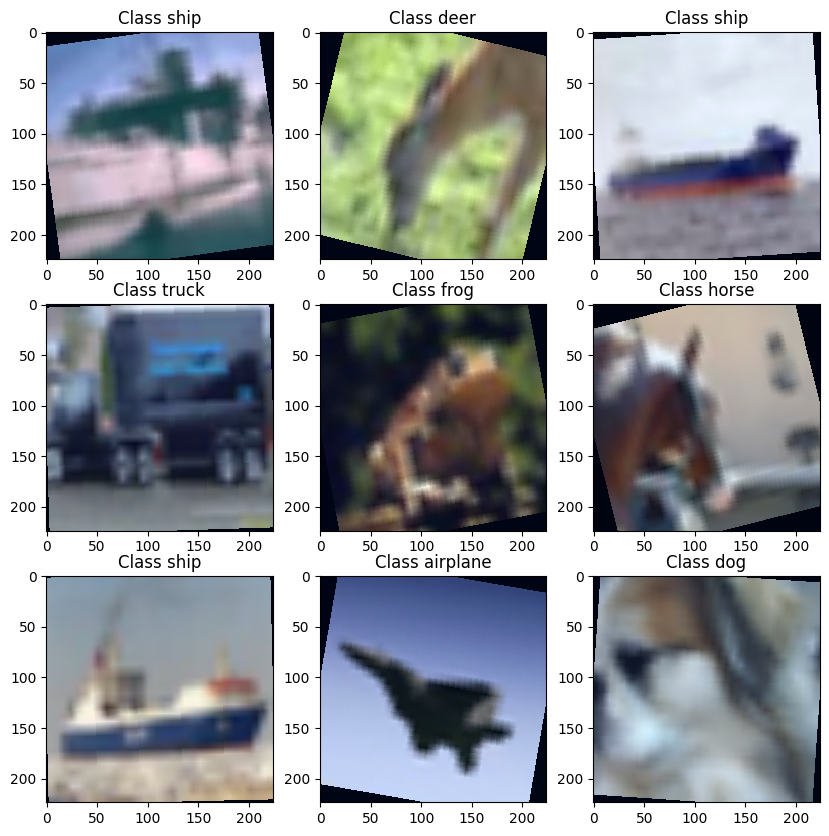

In [15]:
# Plot the images in a 3x3 grid
nrows = 3
ncols = 3
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    img = images[i, :, :, :].numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class {}".format(class_to_string(labels[i])))

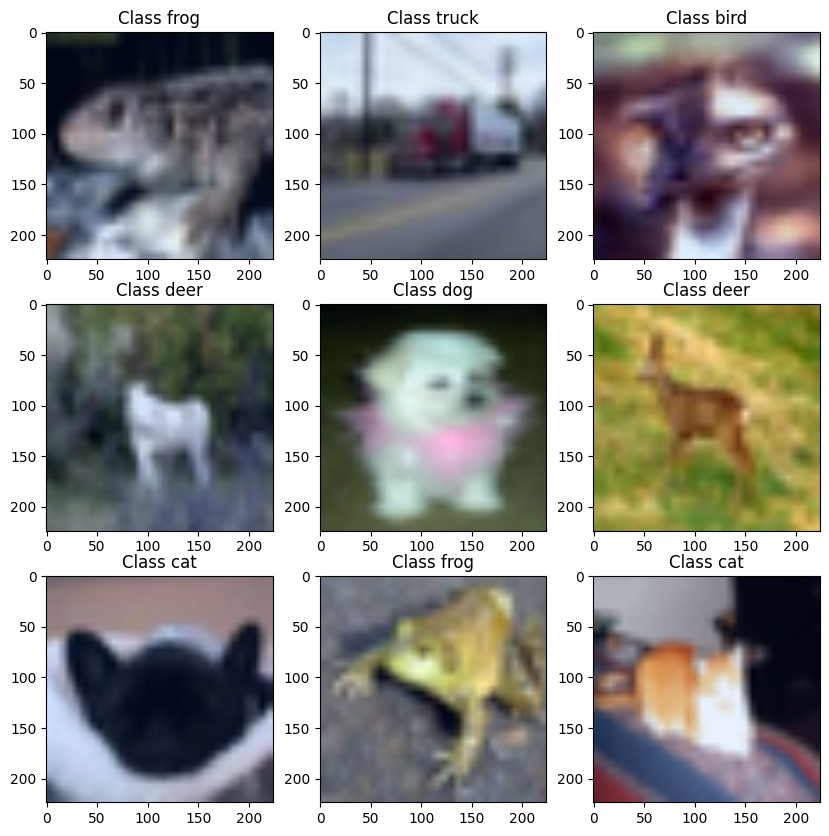

In [16]:
# Plot the test images in a 3x3 grid
images, labels = next(iter(test_loader))
nrows = 3
ncols = 3
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    img = images[i, :, :, :].numpy().transpose((1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class {}".format(class_to_string(labels[i])))

# 3. Design the network.

In [17]:
# Load pre-trained model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [19]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=2e-5)

# 4. Train the network.

In [21]:
def get_accuracy(y_pred, y_true):
    """Calculate the accuracy between predicted and true labels"""
    _, y_pred = torch.max(y_pred, dim=1)
    correct = torch.sum(y_pred == y_true).float()
    acc = correct / len(y_true)
    return acc

In [22]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)

        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)

        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

In [ ]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# Plot training and validation accuracy
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Exercise 1: Experiment with other pre-trained models to evaluate results

In [ ]:
model = models.squeezenet1_1(pretrained=True)

In [ ]:
model

In [ ]:
# Load pre-trained model
model = models.densenet161(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=2e-5)

In [ ]:
train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 5

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        print(i, '/', len(train_loader))
        # Clear gradients
        optimizer.zero_grad()

        # Move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)

        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)

        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

# Exercise 2: Use the concepts learnt to train a classifier for CIFAR100 dataset